### Table of Contents:
- Data collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing — Images
- Data Preprocessing — Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference
- Evaluation

In [179]:
import pandas as pd
import numpy as np

In [36]:
from nltk.tokenize import RegexpTokenizer

In [44]:
tokenizer = RegexpTokenizer("[A-Za-z]+")

### Undersatinding the Data

In [76]:
filename = "./Flickr8k/Flickr8k.lemma.token.txt"
file = open(filename, 'r')
doc = file.read()

In [77]:
print(doc[:2000])

1305564994_00513f9a5b.jpg#0	A man in street racer armor be examine the tire of another racer 's motorbike .
1305564994_00513f9a5b.jpg#1	Two racer drive a white bike down a road .
1305564994_00513f9a5b.jpg#2	Two motorist be ride along on their vehicle that be oddly design and color .
1305564994_00513f9a5b.jpg#3	Two person be in a small race car drive by a green hill .
1305564994_00513f9a5b.jpg#4	Two person in race uniform in a street car .
1351764581_4d4fb1b40f.jpg#0	A firefighter extinguish a fire under the hood of a car .
1351764581_4d4fb1b40f.jpg#1	a fireman spray water into the hood of small white car on a jack
1351764581_4d4fb1b40f.jpg#2	A fireman spray inside the open hood of small white car , on a jack .
1351764581_4d4fb1b40f.jpg#3	A fireman use a firehose on a car engine that be up on a carjack .
1351764581_4d4fb1b40f.jpg#4	Firefighter use water to extinguish a car that be on fire .
1358089136_976e3d2e30.jpg#0	A boy sand surf down a hill
1358089136_976e3d2e30.jpg#1	A man be atte

In [78]:
print(len(doc))

3244761


### Data Cleaning #1

#### Making a dictionary for all images and captions

In [84]:
def caption_dic(doc):
    cap_doc = {}
    for line in doc.split('\n'):
        tokenized = line.split('\t')
        img_name = tokenized[0].split('.')[0]
        try:
            caption = ' '.join(tokenizer.tokenize(tokenized[1]))
        except:
            pass
        if img_name not in cap_doc.keys():
            cap_doc[img_name] = list()
        cap_doc[img_name].append(caption)
        
    return cap_doc

In [67]:
doc.split('\n')[0].split('\t')[0]

'1305564994_00513f9a5b.jpg#0'

In [81]:
' '.join(tokenizer.tokenize(doc.split('\n')[0].split('\t')[1]))

'A man in street racer armor be examine the tire of another racer s motorbike'

In [85]:
dic = caption_dic(doc)

In [86]:
print(len(list(dic.keys())))

8093


In [87]:
print(dic['1305564994_00513f9a5b'])

['A man in street racer armor be examine the tire of another racer s motorbike', 'Two racer drive a white bike down a road', 'Two motorist be ride along on their vehicle that be oddly design and color', 'Two person be in a small race car drive by a green hill', 'Two person in race uniform in a street car']


#### Getting vocab in the data

In [93]:
def get_vocab(dic):
    vocab = set()
    for key in dic.keys():
        [vocab.update(d.split()) for d in dic[key]]
    return vocab

In [94]:
vocab = get_vocab(dic)

In [95]:
print(len(vocab))

7023


In [97]:
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(dic, 'descriptions.txt')

### Loading Training, Testing and Dev Data

In [119]:
def data_dict(dis,path):
    file = open(path, 'r')
    doc = file.read()
    d = {}
    img_ids = []
    for line in doc.split('\n'):
        img_id = line.split('.')[0]
        img_ids.append(img_id)
        if img_id in dis.keys():
            d[img_id] = list()
            captions = dis[img_id]
            for caption in captions:
                caption = 'startseq ' + str(caption) + ' endseq'
                d[img_id].append(caption)
                
    return d, img_ids

In [121]:
train_dict, train_list = data_dict(dic,'./Flickr8k/Flickr_8k.trainImages.txt')

In [123]:
print(len(train_dict.keys()), len(train_list))

6001 6001


In [124]:
test_dict, test_list = data_dict(dic,'./Flickr8k/Flickr_8k.testImages.txt')

In [125]:
len(test_dict.keys())

1001

In [126]:
dev_dict, dev_list = data_dict(dic,'./Flickr8k/Flickr_8k.devImages.txt')

In [127]:
len(dev_dict.keys())

1001

In [128]:
print(list(train_dict.values())[0])

['startseq A black dog be run after a white dog in the snow endseq', 'startseq Black dog chase brown dog through snow endseq', 'startseq Two dog chase each other across the snowy ground endseq', 'startseq Two dog play together in the snow endseq', 'startseq Two dog run through a low lie body of water endseq']


### Data Cleaning #2

In [129]:
all_train_captions = []
for key, val in train_dict.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30001

In [131]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 6032 -> 1387


### Data Preprocessing- Captions

In [132]:
wordtoidx = {}
idxtoword = {}

for i in range(len(vocab)):
    wordtoidx[vocab[i]] = i
    idxtoword[i] = vocab[i]

In [133]:
print(len(wordtoidx),len(idxtoword))

1387 1387


In [140]:
print(wordtoidx['cat'], idxtoword[240])

240 cat


In [146]:
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

In [147]:
# determine the maximum sequence length
max_length = max_length(train_dict)
print('Maximum Description Length: %d' % max_length)

Maximum Description Length: 38


### Data Preprocessing- Images

In [169]:
# Below path contains all the images
images = './Flickr8k/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [160]:
for i in range(len(train_list)):
    train_list[i] = train_list[i] + '.jpg'

In [161]:
print(train_list[:5])

['2513260012_03d33305cf.jpg', '2903617548_d3e38d7f88.jpg', '3338291921_fe7ae0c8f8.jpg', '488416045_1c6d903fe0.jpg', '2644326817_8f45080b87.jpg']


In [170]:
train_img = []
for i in img: # img is list of full path names of all images
    if i[len(images):] in train_list: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [171]:
print(train_img[:5])

['./Flickr8k/Flicker8k_Dataset\\1000268201_693b08cb0e.jpg', './Flickr8k/Flicker8k_Dataset\\1001773457_577c3a7d70.jpg', './Flickr8k/Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg', './Flickr8k/Flicker8k_Dataset\\1003163366_44323f5815.jpg', './Flickr8k/Flicker8k_Dataset\\1007129816_e794419615.jpg']


In [187]:
for i in range(len(train_img)):
    train_img[i] = '/'.join(train_img[i].split('\\'))

In [188]:
print(train_img[:5])

['./Flickr8k/Flicker8k_Dataset/1000268201_693b08cb0e.jpg', './Flickr8k/Flicker8k_Dataset/1001773457_577c3a7d70.jpg', './Flickr8k/Flicker8k_Dataset/1002674143_1b742ab4b8.jpg', './Flickr8k/Flicker8k_Dataset/1003163366_44323f5815.jpg', './Flickr8k/Flicker8k_Dataset/1007129816_e794419615.jpg']


In [172]:
# Below file conatains the names of images to be used in test data
test_images_file = 'Flickr8k/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [189]:
for i in range(len(test_img)):
    test_img[i] = '/'.join(test_img[i].split('\\'))

In [190]:
print(test_img[:5])

['./Flickr8k/Flicker8k_Dataset/1056338697_4f7d7ce270.jpg', './Flickr8k/Flicker8k_Dataset/106490881_5a2dd9b7bd.jpg', './Flickr8k/Flicker8k_Dataset/1082379191_ec1e53f996.jpg', './Flickr8k/Flicker8k_Dataset/1084040636_97d9633581.jpg', './Flickr8k/Flicker8k_Dataset/1096395242_fc69f0ae5a.jpg']


In [151]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

In [152]:
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time

In [156]:
from keras.models import Model

In [201]:
from pickle import dump, load

In [154]:
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 548s 6us/step


In [157]:
model_new = Model(model.input, model.layers[-2].output)

In [158]:
from keras.preprocessing import image

In [174]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [175]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [191]:
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 1022.4075782299042


In [192]:
len(encoding_train)

6000

In [199]:
print(len(list(encoding_train.values())[0]),list(encoding_train.values())[0])

2048 [0.1227762  0.3329491  0.7527179  ... 0.21939681 0.30216378 0.40283182]


In [203]:
with open("Flickr8k/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [204]:
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 157.36680150032043


In [206]:
print(len(encoding_test))

1000


In [207]:
print(len(list(encoding_test.values())[0]),list(encoding_test.values())[0])

2048 [0.45309216 0.2575232  0.11301449 ... 1.1222697  0.34380364 1.015096  ]


In [210]:
with open("Flickr8k/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [270]:
train_features = load(open("Flickr8k/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


### Preprocessing Done!

#### Data Generator

In [216]:
from keras.preprocessing.sequence import pad_sequences

In [280]:
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=len(vocab))[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [223]:
f = open('glove.6B.200d.txt',encoding='utf=8')

In [224]:
embeddings_index = {}
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float')
    embeddings_index[word] = coefs
    
f.close()

In [225]:
emb_dim = embeddings_index['black'].shape
print(emb_dim)

(200,)


In [226]:
print(len(embeddings_index))

400000


In [247]:
embedding_matrix = np.zeros((len(vocab), emb_dim[0]))

for word, i in wordtoidx.items():
    try:
        embedding_vector = embeddings_index[word]
    except:
        pass
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [250]:
embedding_matrix.shape

(1387, 200)

## Building the model now

In [252]:
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional 
from keras import Input, layers

In [276]:
from keras.utils import to_categorical

In [255]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(len(vocab), emb_dim[0], mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(len(vocab), activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [256]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 38)           0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 38, 200)      277400      input_8[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 2048)         0           input_7[0][0]                    
__________________________________________________________________________________________________
dropout_5 

In [257]:
model.layers[2]

In [258]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [259]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [261]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_dict)//number_pics_per_batch

In [ ]:
for i in range(epochs):
    generator = data_generator(train_dict, train_features, wordtoidx, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

In [283]:
with open("Flickr8k/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [289]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [286]:
import matplotlib.pyplot as plt

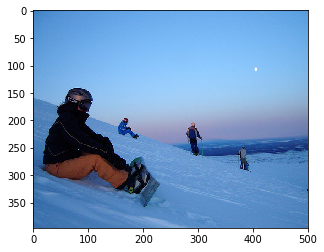

A child in a red coat be ride a snow cover hill


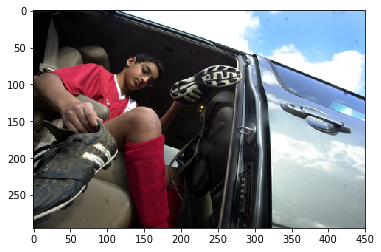

A man in a black shirt and a black hat ride a bike on a street


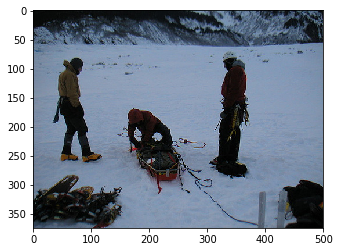

Two child be play in the snow


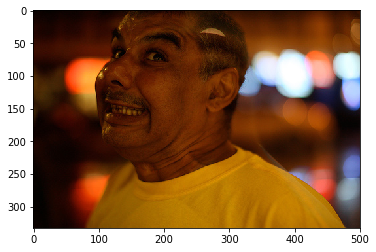

A man in a black shirt and a black cap be wear a black shirt


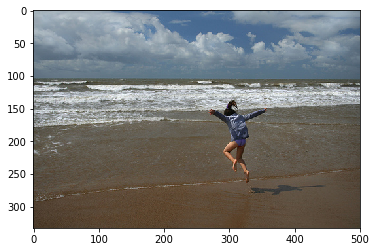

A girl in a bathe suit run on a beach


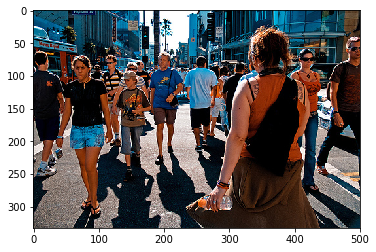

A group of person stand in a street


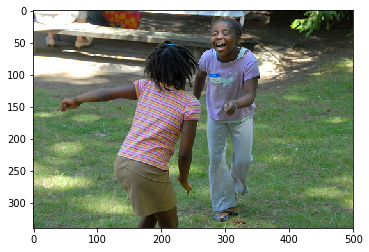

A little girl in a pink dress be run through a grassy field


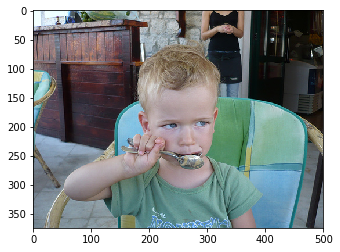

A little girl in a pink shirt be sit on a bed with a towel


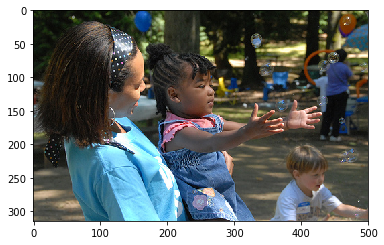

A girl in a pink dress be stand in front of a group of person


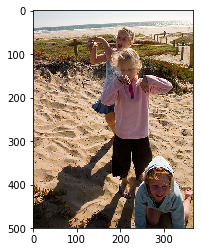

A girl in a bikini be walk on a beach


In [316]:
for i in range(10):
    pic = list(encoding_test.keys())[i+10]
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print(greedySearch(image))